In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision
import os
import numpy as np
import matplotlib.pyplot as plt
import time


transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])


#train_data_path = 'relative path of training data set'
train_data_path = './horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=3, shuffle=False, num_workers=1)  


validation_data_path = './horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=3, shuffle=False, num_workers=1)  





#Initialize Coef to Zeros
coef = np.zeros((1,10001), dtype = float)

#Set Learning Rate
lrnRate = 0.0023

# Set Loss Lists
lrnLoss = list()
valLoss = list()

# Set Accurate Lists
lrnAcc = list()
valAcc = list()

# set Elapsed time Lists
elapTime = list()


epoch = -1
lrnAccRate = 0
while(lrnAccRate < 0.8):
    epoch += 1
    # load training images of the batch size for every iteration
    
    #Set Sum of Derivatives to 0
    sumDCoef = np.zeros((10001,1), dtype = float)
    
    #Set Sum of Loss to 0
    sumL = 0
    
    #Set Sum of Cor to 0
    cor = 0
    
    start_time = time.time()
    for i, data in enumerate(trainloader):
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data
        

        # if you don't change the image size, it will be [batch_size, 1, 100, 100]

        batch_size = inputs.shape[0]



        # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]

        
        # change inputs to matrix 10000*batch_size
        for bat_idx in range(batch_size):
            
            targMat = inputs[bat_idx][0]

            colVec = np.reshape(targMat, (np.product(targMat.shape), 1), 'F')
            
            if(bat_idx == 0):
                batMat = colVec
            else:
                batMat = np.concatenate((batMat, colVec), axis = 1)         
            
        # Add ones because of the value b in coefficient
        ones = np.ones((1, batch_size), dtype = int)
        batMat = np.concatenate((batMat, ones))


        

        # Start Regression Calculation
        z = np.dot(coef, batMat)                                           #coef.shape = (1,10001), batMat.shape = (10001, batch_size), z.shape = (1, batch_size)
        a = 1/(1 + np.exp(-z))                                                 #a.shape = (1, batch_size)
        dz = np.subtract(a, labels)                                        #dz.shape = (1, batch_size)
        batMat = torch.from_numpy(batMat)                       #change ndarray to tensor
        dCoef = dz * batMat                                                 #dCoef.shape = (10001, batch_size)
        sumHelper = np.ones((batch_size,1), dtype = int)    #sumHelper.shape = (batch_size,1)
        sumDCoef += np.dot(dCoef, sumHelper)                 #sumDCoef.shape = (10001, 1)
        
        
        # Calculate Total Loss
        a = torch.from_numpy(a)                       #change ndarray to tensor
        dLabels = labels.double()                      #change tensor type to double
        L = -(dLabels) * np.log(a) - (1-dLabels) * np.log(1-a)      #labels.shape = (1, batch_size), L.shape = (1,batch_size)
        sumL += L.sum()
        
        
        
        # Calculate Accuracy
        

        for batIdx in range(batch_size):

            if(a[0][batIdx] <= 0.5 and labels[batIdx] == 0):
                cor += 1

            if(a[0][batIdx] > 0.5 and labels[batIdx] == 1):
                cor += 1
            
        
    
    totalDataNum = len(trainloader.dataset)
        
    # Calculate dLossdCoef

    sumDCoef /= totalDataNum

    # Update coefs using derivatives
    coef = coef.T
    coef -= lrnRate * sumDCoef
    coef = coef.T
    
    elapsed_time = time.time() - start_time
    elapTime.append(elapsed_time)


    # Calculate TotalLoss
    sumL /= totalDataNum

    lrnLoss.append(sumL)
    
    
    # Calculate Accuracy
    
    lrnAccRate = cor/totalDataNum
    lrnAcc.append(lrnAccRate)
    
                


    # Set Sum Of Valid Loss to 0
    sumVL = 0
    # Set Sum of Valid Cor to 0
    vCor = 0
    
    # load validation images of the batch size for every iteration
    for i, data in enumerate(valloader):
        
        # inputs is the image
        # labels is the class of the image
        inputs, labels = data
        
        # if you don't change the image size, it will be [batch_size, 1, 100, 100]
         # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]

        batch_size = inputs.shape[0]
        
    
        # Change Inputs to matrix 10000*batch_size
        
        for bat_idx in range(batch_size):
            targMat = inputs[bat_idx][0]
            colVec = np.reshape(targMat, (np.product(targMat.shape), 1), 'F')
            
            if(bat_idx == 0):
                batMat = colVec
            else:
                batMat = np.concatenate((batMat,colVec), axis = 1)
                
            
            
        # Add ones because of the value b in coefficient
        ones = np.ones((1, batch_size), dtype = int)
        batMat = np.concatenate((batMat, ones))

        
        # Start Calculate Loss 
        z = np.dot(coef, batMat)
        a = 1/(1+np.exp(-z))
        a = torch.from_numpy(a)
        dLabels = labels.double()
        L = -(dLabels) * np.log(a) - (1-dLabels) * np.log(1-a)
        sumVL += L.sum()

        
        # Calculate Accuracy
        
        for batIdx in range(batch_size):
            if(a[0][batIdx] <= 0.5 and labels[batIdx] == 0):
                vCor += 1
                
            if(a[0][batIdx] > 0.5 and labels[batIdx] == 1):
                vCor += 1
    
    totalValDataNum = len(valloader.dataset)
    
    # CalCulate Total Loss
    sumVL /= totalValDataNum
    valLoss.append(sumVL)
    
    
    # Calculate Accuracy
    vAcc = vCor/totalValDataNum
    valAcc.append(vAcc)
    
    
    print("epoch : ",epoch,',', "lrnCor : ", cor, "valCor : ", vCor, "elapsed time : ", elapsed_time)
    
    

epoch :  0 , lrnCor :  500 valCor :  128 elapsed time :  1.226099967956543
epoch :  1 , lrnCor :  527 valCor :  129 elapsed time :  1.1933181285858154
epoch :  2 , lrnCor :  562 valCor :  128 elapsed time :  1.1898901462554932
epoch :  3 , lrnCor :  527 valCor :  137 elapsed time :  1.1881182193756104
epoch :  4 , lrnCor :  572 valCor :  129 elapsed time :  1.2339508533477783
epoch :  5 , lrnCor :  561 valCor :  151 elapsed time :  1.284688949584961
epoch :  6 , lrnCor :  576 valCor :  142 elapsed time :  1.2713379859924316
epoch :  7 , lrnCor :  578 valCor :  176 elapsed time :  1.262782335281372
epoch :  8 , lrnCor :  602 valCor :  174 elapsed time :  1.2722480297088623
epoch :  9 , lrnCor :  601 valCor :  189 elapsed time :  1.1777970790863037
epoch :  10 , lrnCor :  638 valCor :  191 elapsed time :  1.1996030807495117
epoch :  11 , lrnCor :  641 valCor :  205 elapsed time :  1.1876661777496338
epoch :  12 , lrnCor :  661 valCor :  209 elapsed time :  1.1850521564483643
epoch :  13 

epoch :  107 , lrnCor :  791 valCor :  223 elapsed time :  1.2012319564819336
epoch :  108 , lrnCor :  791 valCor :  222 elapsed time :  1.193490982055664
epoch :  109 , lrnCor :  792 valCor :  222 elapsed time :  1.194598913192749
epoch :  110 , lrnCor :  793 valCor :  222 elapsed time :  1.1840810775756836
epoch :  111 , lrnCor :  795 valCor :  222 elapsed time :  1.188918113708496
epoch :  112 , lrnCor :  794 valCor :  223 elapsed time :  1.217283010482788
epoch :  113 , lrnCor :  795 valCor :  223 elapsed time :  1.2100989818572998
epoch :  114 , lrnCor :  795 valCor :  223 elapsed time :  1.183128833770752
epoch :  115 , lrnCor :  796 valCor :  223 elapsed time :  1.1989860534667969
epoch :  116 , lrnCor :  796 valCor :  223 elapsed time :  1.1998319625854492
epoch :  117 , lrnCor :  796 valCor :  223 elapsed time :  1.1859650611877441
epoch :  118 , lrnCor :  797 valCor :  223 elapsed time :  1.2166800498962402
epoch :  119 , lrnCor :  797 valCor :  223 elapsed time :  1.22126007

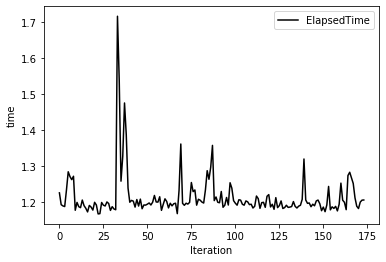

In [8]:
plt.plot(elapTime, color = 'black', label = "ElapsedTime")
plt.xlabel("Iteration")
plt.ylabel("time")
plt.legend()


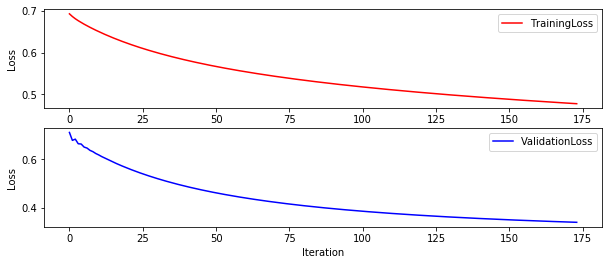

In [9]:
#Plotting Loss

fig, axs = plt.subplots(2,1, figsize = (10,4))


axs[0].plot(lrnLoss, color = 'red', label = "TrainingLoss")


axs[1].plot(valLoss, color = 'blue', label = "ValidationLoss")

axs[0].set(ylabel = 'Loss')
axs[1].set(xlabel = 'Iteration', ylabel = 'Loss')

axs[0].legend()
axs[1].legend()

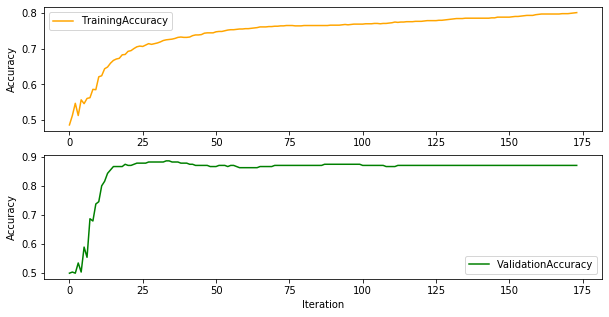

In [10]:
#Plotting Accuracy
fig, axs = plt.subplots(2,1, figsize = (10,5))


axs[0].plot(lrnAcc, color = 'orange', label = "TrainingAccuracy")


axs[1].plot(valAcc, color = 'green', label = "ValidationAccuracy")

axs[0].set(ylabel = 'Accuracy')
axs[1].set(xlabel = 'Iteration', ylabel = 'Accuracy')

axs[0].legend()
axs[1].legend()

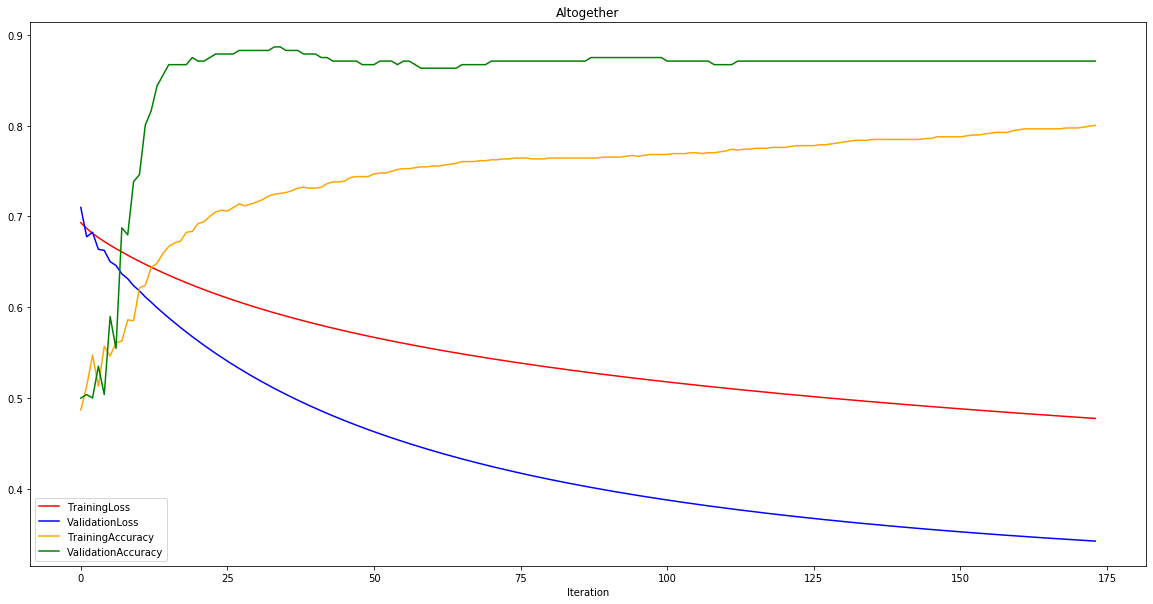

In [11]:
#Plotting Altogether

plt.figure(figsize = (20,10))
plt.title('Altogether')
plt.xlabel('Iteration')

plt.plot(lrnLoss, color = 'red', label = 'TrainingLoss')
plt.plot(valLoss, color = 'blue', label = "ValidationLoss")
plt.plot(lrnAcc, color = 'orange', label = "TrainingAccuracy")
plt.plot(valAcc, color = 'green', label = "ValidationAccuracy")

plt.legend()





In [12]:
print("  Dataset   |   Loss   | Accuracy")

print("  Training  | %.4f | %.4f" % (lrnLoss[-1], lrnAcc[-1]))
print(" Validation| %.4f | %.4f" % (valLoss[-1], valAcc[-1]))

  Dataset   |   Loss   | Accuracy
  Training  | 0.4776 | 0.8004
 Validation| 0.3425 | 0.8711
